# PyTorch Advanced: Custom Layers and Deep Architectures

## Part 2: Building Complex Operations from Scratch

---

In Part 1, we learned PyTorch fundamentals, autograd basics, and the high-level nn.Module API. Now we go deeper!

### What You'll Learn

| Part | Topic | Key Concepts |
|------|-------|-------------|
| **I** | Advanced Autograd | Nested autograd, Jacobians, custom gradients |
| **II** | Building Ops from Scratch | Convolution, pooling, normalization by hand |
| **III** | Custom Layers (Primitives) | Build layers using only torch.nn.Parameter |
| **IV** | Custom nn.Module Layers | Proper subclassing with forward() |
| **V** | Advanced Architectures | Residual blocks, attention, custom normalizations |
| **VI** | Custom Training Loops | Full control over training |
| **VII** | Practical Demos | Real-world examples with custom components |

---

*"To understand the framework, build it from scratch."*

In [1]:
# ============================================================================
#                           SETUP & IMPORTS
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Callable, Union

# Beautiful plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Check versions and GPU
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available:  {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device:      {torch.cuda.get_device_name(0)}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("\nReady for Advanced PyTorch!")

PyTorch Version: 2.9.0+cpu
CUDA Available:  False

Using device: cpu

Ready for Advanced PyTorch!


---

# Part I: Advanced Autograd Patterns

## Beyond Basic Gradient Computation

In Part 1, we used autograd for simple gradients. Now we'll explore:

- **Nested autograd** for higher-order derivatives
- **Jacobian and Hessian** computation
- **Custom gradients** with torch.autograd.Function
- **Gradient hooks** for manipulation

In [2]:
# ============================================================================
#                    NESTED AUTOGRAD: HIGHER-ORDER DERIVATIVES
# ============================================================================

print("="*60)
print("       NESTED AUTOGRAD: HIGHER-ORDER DERIVATIVES")
print("="*60)

# Example: Compute first, second, and third derivatives
# f(x) = x^4
# f'(x) = 4x^3
# f''(x) = 12x^2
# f'''(x) = 24x

x = torch.tensor(2.0, requires_grad=True)

# First derivative
y = x ** 4
dy_dx = torch.autograd.grad(y, x, create_graph=True)[0]

# Second derivative (need create_graph=True to continue differentiating)
d2y_dx2 = torch.autograd.grad(dy_dx, x, create_graph=True)[0]

# Third derivative
d3y_dx3 = torch.autograd.grad(d2y_dx2, x)[0]

print(f"\nf(x) = x^4, evaluated at x = {x.item()}")
print(f"")
print(f"f(x)    = {y.item():.1f}         (expected: 16)")
print(f"f'(x)   = {dy_dx.item():.1f}         (expected: 32 = 4*8)")
print(f"f''(x)  = {d2y_dx2.item():.1f}         (expected: 48 = 12*4)")
print(f"f'''(x) = {d3y_dx3.item():.1f}         (expected: 48 = 24*2)")

       NESTED AUTOGRAD: HIGHER-ORDER DERIVATIVES

f(x) = x^4, evaluated at x = 2.0

f(x)    = 16.0         (expected: 16)
f'(x)   = 32.0         (expected: 32 = 4*8)
f''(x)  = 48.0         (expected: 48 = 12*4)
f'''(x) = 48.0         (expected: 48 = 24*2)


In [3]:
# ============================================================================
#                    JACOBIAN COMPUTATION
# ============================================================================

print("="*60)
print("              JACOBIAN COMPUTATION")
print("="*60)

# The Jacobian is the matrix of all first-order partial derivatives
# For f: R^n -> R^m, the Jacobian J is m x n where J[i,j] = df_i/dx_j

x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

# Vector function: f(x) = [x1^2, x1*x2, sin(x3)]
def f(x):
    return torch.stack([
        x[0] ** 2,
        x[0] * x[1],
        torch.sin(x[2])
    ])

# Compute full Jacobian using torch.autograd.functional.jacobian
jacobian = torch.autograd.functional.jacobian(f, x)

print(f"\nx = {x.tolist()}")
print(f"y = f(x) = [x1^2, x1*x2, sin(x3)] = {f(x).tolist()}")
print(f"\nJacobian (3x3):")
print(f"{jacobian.numpy()}")

print(f"\nExpected Jacobian:")
print(f"  [2*x1,   0,      0   ]   = [2,   0,     0     ]")
print(f"  [x2,     x1,     0   ]   = [2,   1,     0     ]")
print(f"  [0,      0,  cos(x3) ]   = [0,   0,  {np.cos(3):.4f}]")

              JACOBIAN COMPUTATION

x = [1.0, 2.0, 3.0]
y = f(x) = [x1^2, x1*x2, sin(x3)] = [1.0, 2.0, 0.14112000167369843]

Jacobian (3x3):
[[ 2.         0.         0.       ]
 [ 2.         1.         0.       ]
 [ 0.         0.        -0.9899925]]

Expected Jacobian:
  [2*x1,   0,      0   ]   = [2,   0,     0     ]
  [x2,     x1,     0   ]   = [2,   1,     0     ]
  [0,      0,  cos(x3) ]   = [0,   0,  -0.9900]


In [4]:
# ============================================================================
#                    HESSIAN COMPUTATION
# ============================================================================

print("="*60)
print("              HESSIAN COMPUTATION")
print("="*60)

# The Hessian is the matrix of second-order partial derivatives
# H[i,j] = d^2f / (dx_i dx_j)

x = torch.tensor([1.0, 2.0], requires_grad=True)

# Scalar function: f(x, y) = x^2*y + y^3
def scalar_fn(x):
    return x[0]**2 * x[1] + x[1]**3

# Compute Hessian using torch.autograd.functional.hessian
hessian = torch.autograd.functional.hessian(scalar_fn, x)

# Also compute gradient for reference
f_val = scalar_fn(x)
grad = torch.autograd.grad(f_val, x, create_graph=True)[0]

print(f"\nf(x, y) = x^2*y + y^3, at (x, y) = ({x[0].item()}, {x[1].item()})")
print(f"f = {f_val.item()}")
print(f"\nGradient: {grad.tolist()}")
print(f"  Expected: [2xy, x^2 + 3y^2] = [4, 13]")
print(f"\nHessian:")
print(f"{hessian.numpy()}")
print(f"  Expected:")
print(f"  [2y,  2x ]   = [4, 2]")
print(f"  [2x,  6y ]   = [2, 12]")

              HESSIAN COMPUTATION

f(x, y) = x^2*y + y^3, at (x, y) = (1.0, 2.0)
f = 10.0

Gradient: [4.0, 13.0]
  Expected: [2xy, x^2 + 3y^2] = [4, 13]

Hessian:
[[ 4.  2.]
 [ 2. 12.]]
  Expected:
  [2y,  2x ]   = [4, 2]
  [2x,  6y ]   = [2, 12]


In [5]:
# ============================================================================
#                    CUSTOM AUTOGRAD FUNCTIONS
# ============================================================================

print("="*60)
print("           CUSTOM AUTOGRAD FUNCTIONS")
print("="*60)

# torch.autograd.Function allows you to define custom forward and backward passes
# This is the PyTorch equivalent of TensorFlow's @tf.custom_gradient

class ClipGradientNorm(torch.autograd.Function):
    """
    Forward: identity function
    Backward: clip gradient norm
    """
    @staticmethod
    def forward(ctx, x, clip_value):
        # Save clip_value for backward
        ctx.clip_value = clip_value
        return x.clone()

    @staticmethod
    def backward(ctx, grad_output):
        # Clip the incoming gradient
        norm = grad_output.norm()
        if norm > ctx.clip_value:
            grad_output = grad_output * ctx.clip_value / norm
        # Return gradients for x and None for clip_value (not differentiable)
        return grad_output, None

# Convenience function
def clip_gradient_norm(x, clip_value=1.0):
    return ClipGradientNorm.apply(x, clip_value)

# Test custom gradient
x = torch.tensor([3.0, 4.0], requires_grad=True)  # Gradient will have norm 5

y = clip_gradient_norm(x, clip_value=1.0)
loss = y.sum()
loss.backward()

print(f"\nInput: {x.tolist()}")
print(f"Gradient (clipped to norm 1.0): {x.grad.tolist()}")
print(f"Gradient norm: {x.grad.norm().item():.4f}")

           CUSTOM AUTOGRAD FUNCTIONS

Input: [3.0, 4.0]
Gradient (clipped to norm 1.0): [0.7071067690849304, 0.7071067690849304]
Gradient norm: 1.0000


In [6]:
# ============================================================================
#                    STRAIGHT-THROUGH ESTIMATOR
# ============================================================================

print("="*60)
print("         STRAIGHT-THROUGH ESTIMATOR")
print("="*60)

# The straight-through estimator is used for:
# - Binary/discrete operations that are non-differentiable
# - Quantization in neural networks

class StraightThroughRound(torch.autograd.Function):
    """
    Forward: round to nearest integer
    Backward: pass gradient through unchanged (identity)
    """
    @staticmethod
    def forward(ctx, x):
        return torch.round(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output  # Straight-through: gradient = identity

class StraightThroughSign(torch.autograd.Function):
    """
    Forward: sign function (-1, 0, or 1)
    Backward: gradient of hard tanh (1 if |x| <= 1, else 0)
    """
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return torch.sign(x)

    @staticmethod
    def backward(ctx, grad_output):
        x, = ctx.saved_tensors
        # Gradient is 1 where |x| <= 1, 0 elsewhere
        return grad_output * (x.abs() <= 1).float()

# Convenience functions
straight_through_round = StraightThroughRound.apply
straight_through_sign = StraightThroughSign.apply

# Test
x = torch.tensor([0.3, 0.7, 1.2, 2.5], requires_grad=True)

y = straight_through_round(x)
loss = (y ** 2).sum()
loss.backward()

print(f"\nInput:   {x.tolist()}")
print(f"Rounded: {y.tolist()}")
print(f"Gradient (straight-through): {x.grad.tolist()}")
print(f"\n Note: Round is non-differentiable, but we can still train!")

         STRAIGHT-THROUGH ESTIMATOR

Input:   [0.30000001192092896, 0.699999988079071, 1.2000000476837158, 2.5]
Rounded: [0.0, 1.0, 1.0, 2.0]
Gradient (straight-through): [0.0, 2.0, 2.0, 4.0]

 Note: Round is non-differentiable, but we can still train!


In [7]:
# ============================================================================
#                    GRADIENT HOOKS
# ============================================================================

print("="*60)
print("               GRADIENT HOOKS")
print("="*60)

# Hooks allow you to inspect or modify gradients during backward pass
# register_hook() on tensors, register_backward_hook() on modules

gradient_log = []

def gradient_logger_hook(grad):
    """Hook that logs gradient statistics."""
    gradient_log.append({
        'mean': grad.mean().item(),
        'std': grad.std().item(),
        'norm': grad.norm().item()
    })
    return grad  # Return unchanged gradient

def gradient_clip_hook(max_norm):
    """Create a hook that clips gradient norm."""
    def hook(grad):
        norm = grad.norm()
        if norm > max_norm:
            return grad * max_norm / norm
        return grad
    return hook

# Example: Log gradients during training
x = torch.randn(10, requires_grad=True)
handle = x.register_hook(gradient_logger_hook)

# Forward and backward
y = (x ** 2).sum()
y.backward()

print(f"\nGradient logged:")
print(f"  Mean: {gradient_log[-1]['mean']:.4f}")
print(f"  Std:  {gradient_log[-1]['std']:.4f}")
print(f"  Norm: {gradient_log[-1]['norm']:.4f}")

# Remove hook when done
handle.remove()

print("\n Hooks are powerful for:")
print("  - Debugging gradient flow")
print("  - Gradient clipping per-tensor")
print("  - Feature visualization (GradCAM)")

               GRADIENT HOOKS

Gradient logged:
  Mean: 0.3841
  Std:  1.7298
  Norm: 5.3297

 Hooks are powerful for:
  - Debugging gradient flow
  - Gradient clipping per-tensor
  - Feature visualization (GradCAM)


In [8]:
# ============================================================================
#                    GRADIENT ACCUMULATION
# ============================================================================

print("="*60)
print("            GRADIENT ACCUMULATION")
print("="*60)

# Gradient accumulation is useful when:
# - Batch size is too large for GPU memory
# - You want effective larger batch sizes

def train_with_accumulation(model, data, labels, batch_size, accumulation_steps, optimizer, loss_fn):
    """
    Train with gradient accumulation.
    Effective batch size = batch_size * accumulation_steps
    """
    n_samples = len(data)
    model.train()

    # Zero gradients once at the start
    optimizer.zero_grad()

    for step in range(accumulation_steps):
        # Get mini-batch
        start = (step * batch_size) % n_samples
        end = start + batch_size
        x_batch = data[start:end]
        y_batch = labels[start:end]

        # Forward pass
        predictions = model(x_batch)
        loss = loss_fn(predictions, y_batch)

        # Scale loss by accumulation steps (to average gradients)
        loss = loss / accumulation_steps

        # Backward pass - gradients accumulate!
        loss.backward()

    # Apply accumulated gradients
    optimizer.step()

    return loss.item() * accumulation_steps  # Return unscaled loss

print("\nGradient Accumulation Pattern:")
print("  1. optimizer.zero_grad() once at start")
print("  2. Scale loss by 1/accumulation_steps")
print("  3. loss.backward() accumulates gradients")
print("  4. optimizer.step() after all steps")
print("  5. Effective batch = mini_batch * N")

            GRADIENT ACCUMULATION

Gradient Accumulation Pattern:
  1. optimizer.zero_grad() once at start
  2. Scale loss by 1/accumulation_steps
  3. loss.backward() accumulates gradients
  4. optimizer.step() after all steps
  5. Effective batch = mini_batch * N


---

# Part II: Building Operations from Scratch

## Understanding Neural Network Primitives

Before using nn.Module layers, let's understand what they do by building them ourselves.

In [9]:
# ============================================================================
#                    CONVOLUTION FROM SCRATCH
# ============================================================================

print("="*60)
print("           CONVOLUTION FROM SCRATCH")
print("="*60)

def conv2d_naive(input_tensor, kernel, stride=1, padding=0):
    """
    Naive 2D convolution implementation.

    Parameters
    ----------
    input_tensor : tensor (batch, in_channels, height, width)
    kernel : tensor (out_channels, in_channels, kernel_h, kernel_w)
    stride : int
    padding : int
    """
    batch_size, in_channels, in_h, in_w = input_tensor.shape
    out_channels, _, k_h, k_w = kernel.shape

    # Apply padding
    if padding > 0:
        input_tensor = F.pad(input_tensor, [padding] * 4)
        in_h += 2 * padding
        in_w += 2 * padding

    out_h = (in_h - k_h) // stride + 1
    out_w = (in_w - k_w) // stride + 1

    output = torch.zeros(batch_size, out_channels, out_h, out_w)

    for i in range(out_h):
        for j in range(out_w):
            h_start = i * stride
            w_start = j * stride
            # Extract patch: (batch, in_channels, k_h, k_w)
            patch = input_tensor[:, :, h_start:h_start+k_h, w_start:w_start+k_w]

            # Convolve: sum over (in_channels, k_h, k_w)
            # patch: (batch, in_c, k_h, k_w)
            # kernel: (out_c, in_c, k_h, k_w)
            # output: (batch, out_c)
            conv = torch.einsum('bihw,oihw->bo', patch, kernel)
            output[:, :, i, j] = conv

    return output

# Test our implementation
x = torch.randn(1, 1, 5, 5)  # 1 image, 1 channel, 5x5
kernel = torch.randn(2, 1, 3, 3)  # 2 output channels, 1 input channel, 3x3

our_output = conv2d_naive(x, kernel, stride=1, padding=0)
torch_output = F.conv2d(x, kernel, stride=1, padding=0)

print(f"\nInput shape:  {x.shape}")
print(f"Kernel shape: {kernel.shape}")
print(f"Output shape: {our_output.shape}")
print(f"Matches F.conv2d: {torch.allclose(our_output, torch_output, atol=1e-5)}")

           CONVOLUTION FROM SCRATCH

Input shape:  torch.Size([1, 1, 5, 5])
Kernel shape: torch.Size([2, 1, 3, 3])
Output shape: torch.Size([1, 2, 3, 3])
Matches F.conv2d: True


In [10]:
# ============================================================================
#                    MAX POOLING FROM SCRATCH
# ============================================================================

print("="*60)
print("           MAX POOLING FROM SCRATCH")
print("="*60)

def max_pool2d_naive(input_tensor, pool_size=2, stride=2):
    """
    Naive max pooling implementation.

    For each pool_size x pool_size window, take the maximum.
    """
    batch_size, channels, in_h, in_w = input_tensor.shape

    out_h = (in_h - pool_size) // stride + 1
    out_w = (in_w - pool_size) // stride + 1

    output = torch.zeros(batch_size, channels, out_h, out_w)

    for i in range(out_h):
        for j in range(out_w):
            h_start = i * stride
            w_start = j * stride
            # Extract window
            window = input_tensor[:, :, h_start:h_start+pool_size,
                                  w_start:w_start+pool_size]
            # Max over spatial dimensions
            output[:, :, i, j] = window.amax(dim=(2, 3))

    return output

# Test
x = torch.tensor([[[[1., 2., 3., 4.],
                    [5., 6., 7., 8.],
                    [9., 10., 11., 12.],
                    [13., 14., 15., 16.]]]])

print(f"\nInput shape: {x.shape}")
print(f"Input:")
print(x[0, 0].numpy())

our_pool = max_pool2d_naive(x, pool_size=2, stride=2)
torch_pool = F.max_pool2d(x, kernel_size=2, stride=2)

print(f"\nOutput shape: {our_pool.shape}")
print(f"Output:")
print(our_pool[0, 0].numpy())
print(f"\nMatches F.max_pool2d: {torch.allclose(our_pool, torch_pool)}")

           MAX POOLING FROM SCRATCH

Input shape: torch.Size([1, 1, 4, 4])
Input:
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]

Output shape: torch.Size([1, 1, 2, 2])
Output:
[[ 6.  8.]
 [14. 16.]]

Matches F.max_pool2d: True


In [11]:
# ============================================================================
#                    BATCH NORMALIZATION FROM SCRATCH
# ============================================================================

print("="*60)
print("        BATCH NORMALIZATION FROM SCRATCH")
print("="*60)

class BatchNormFromScratch:
    """
    Batch Normalization implemented from scratch.

    During training:
        x_norm = (x - batch_mean) / sqrt(batch_var + epsilon)
        y = gamma * x_norm + beta

    During inference:
        Use running mean and variance instead of batch statistics.
    """

    def __init__(self, num_features, epsilon=1e-5, momentum=0.1):
        self.epsilon = epsilon
        self.momentum = momentum

        # Learnable parameters
        self.gamma = torch.ones(num_features, requires_grad=True)
        self.beta = torch.zeros(num_features, requires_grad=True)

        # Running statistics (not trainable)
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)

    def __call__(self, x, training=True):
        if training:
            # Compute batch statistics
            batch_mean = x.mean(dim=0)
            batch_var = x.var(dim=0, unbiased=False)

            # Update running statistics (detached, no gradient)
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var

            mean, var = batch_mean, batch_var
        else:
            mean, var = self.running_mean, self.running_var

        # Normalize
        x_norm = (x - mean) / torch.sqrt(var + self.epsilon)

        # Scale and shift
        return self.gamma * x_norm + self.beta

    def parameters(self):
        return [self.gamma, self.beta]

# Test
bn = BatchNormFromScratch(num_features=4)
x = torch.randn(8, 4)  # Batch of 8, 4 features

y_train = bn(x, training=True)
y_eval = bn(x, training=False)

print(f"\nInput shape: {x.shape}")
print(f"Input mean per feature: {x.mean(dim=0).tolist()}")
print(f"Input std per feature:  {x.std(dim=0).tolist()}")
print(f"\nOutput (training) mean: {[f'{v:.4f}' for v in y_train.mean(dim=0).tolist()]}")
print(f"Output (training) std:  {[f'{v:.4f}' for v in y_train.std(dim=0).tolist()]}")
print(f"\n After BatchNorm, each feature has ~0 mean and ~1 std!")

        BATCH NORMALIZATION FROM SCRATCH

Input shape: torch.Size([8, 4])
Input mean per feature: [0.5206222534179688, -0.17970936000347137, 0.45833995938301086, 0.2649056315422058]
Input std per feature:  [0.3801516592502594, 1.219132661819458, 0.4272221326828003, 0.585858941078186]

Output (training) mean: ['-0.0000', '0.0000', '0.0000', '0.0000']
Output (training) std:  ['1.0690', '1.0690', '1.0690', '1.0690']

 After BatchNorm, each feature has ~0 mean and ~1 std!


In [12]:
# ============================================================================
#                    LAYER NORMALIZATION FROM SCRATCH
# ============================================================================

print("="*60)
print("        LAYER NORMALIZATION FROM SCRATCH")
print("="*60)

class LayerNormFromScratch:
    """
    Layer Normalization: Normalize across features (not batch).

    Used in Transformers because:
    - Works with any batch size (including 1)
    - No running statistics needed
    - Each sample normalized independently
    """

    def __init__(self, normalized_shape, epsilon=1e-5):
        self.epsilon = epsilon
        self.normalized_shape = normalized_shape

        # Learnable parameters
        self.gamma = torch.ones(normalized_shape, requires_grad=True)
        self.beta = torch.zeros(normalized_shape, requires_grad=True)

    def __call__(self, x):
        # Compute statistics across last dimensions
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)

        # Normalize
        x_norm = (x - mean) / torch.sqrt(var + self.epsilon)

        # Scale and shift
        return self.gamma * x_norm + self.beta

    def parameters(self):
        return [self.gamma, self.beta]

# Test
ln = LayerNormFromScratch(normalized_shape=4)
x = torch.randn(2, 3, 4)  # (batch, seq, features)

y = ln(x)

print(f"\nInput shape: {x.shape}")
print(f"\nFor sample [0, 0, :]:")
print(f"  Input:  {x[0, 0, :].tolist()}")
print(f"  Output: {[f'{v:.4f}' for v in y[0, 0, :].tolist()]}")
print(f"  Output mean: {y[0, 0, :].mean().item():.6f}")
print(f"  Output std:  {y[0, 0, :].std().item():.4f}")

print(f"\n Key difference:")
print(f"  BatchNorm: normalize across batch (for each feature)")
print(f"  LayerNorm: normalize across features (for each sample)")

        LAYER NORMALIZATION FROM SCRATCH

Input shape: torch.Size([2, 3, 4])

For sample [0, 0, :]:
  Input:  [-0.16911523044109344, 1.931160569190979, 1.0118638277053833, -1.4364064931869507]
  Output: ['-0.3981', '1.2626', '0.5357', '-1.4002']
  Output mean: 0.000000
  Output std:  1.1547

 Key difference:
  BatchNorm: normalize across batch (for each feature)
  LayerNorm: normalize across features (for each sample)


In [13]:
# ============================================================================
#                    DROPOUT FROM SCRATCH
# ============================================================================

print("="*60)
print("            DROPOUT FROM SCRATCH")
print("="*60)

def dropout_from_scratch(x, rate=0.5, training=True):
    """
    Dropout: Randomly zero out neurons during training.

    Key insight: Scale by 1/(1-rate) during training so that
    expected value remains the same during inference.
    """
    if not training or rate == 0:
        return x

    # Create random mask
    keep_prob = 1 - rate
    mask = (torch.rand_like(x) < keep_prob).float()

    # Apply mask and scale (inverted dropout)
    return (x * mask) / keep_prob

# Test
x = torch.ones(2, 10)

print(f"Input: all ones, shape {x.shape}")
print(f"")

# Multiple dropout samples
for i in range(3):
    dropped = dropout_from_scratch(x, rate=0.5, training=True)
    print(f"Dropout sample {i+1}: {dropped[0].tolist()}")

print(f"\nDuring inference (training=False):")
print(f"  Output: {dropout_from_scratch(x, rate=0.5, training=False)[0].tolist()}")

# Verify expected value is preserved
samples = torch.stack([dropout_from_scratch(x, rate=0.5) for _ in range(1000)])
print(f"\nAverage over 1000 samples: {samples.mean().item():.4f} (should be ~1.0)")

            DROPOUT FROM SCRATCH
Input: all ones, shape torch.Size([2, 10])

Dropout sample 1: [0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0]
Dropout sample 2: [2.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 0.0]
Dropout sample 3: [2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0]

During inference (training=False):
  Output: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Average over 1000 samples: 1.0055 (should be ~1.0)


---

# Part III: Custom Layers Using Primitives

## Building Layers with nn.Parameter Only

Before using PyTorch's layer classes, let's build fully functional layers using only basic operations. This shows exactly what happens under the hood.

In [14]:
# ============================================================================
#                    DENSE LAYER FROM PRIMITIVES
# ============================================================================

print("="*60)
print("          DENSE LAYER FROM PRIMITIVES")
print("="*60)

class DenseLayerPrimitive:
    """
    Fully connected layer using only basic PyTorch operations.

    Mathematically: y = activation(x @ W + b)
    """

    def __init__(self, in_features, out_features, activation=None, use_bias=True):
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias

        # Select activation
        self.activation = {
            None: lambda x: x,
            'relu': F.relu,
            'sigmoid': torch.sigmoid,
            'tanh': torch.tanh,
            'softmax': lambda x: F.softmax(x, dim=-1)
        }.get(activation, activation)  # Allow passing functions directly

        # He initialization for weights
        stddev = np.sqrt(2.0 / in_features)
        self.W = torch.randn(in_features, out_features, requires_grad=True) * stddev

        if use_bias:
            self.b = torch.zeros(out_features, requires_grad=True)
        else:
            self.b = None

    def __call__(self, x):
        """Forward pass: y = activation(x @ W + b)"""
        out = x @ self.W
        if self.use_bias:
            out = out + self.b
        return self.activation(out)

    def parameters(self):
        if self.use_bias:
            return [self.W, self.b]
        return [self.W]

    def __repr__(self):
        return f"DenseLayerPrimitive({self.in_features}, {self.out_features})"

# Test
dense = DenseLayerPrimitive(4, 3, activation='relu')
x = torch.randn(2, 4)
y = dense(x)

print(f"\nDenseLayerPrimitive(4, 3, activation='relu')")
print(f"Input shape:  {x.shape}")
print(f"Output shape: {y.shape}")
print(f"Weight shape: {dense.W.shape}")
print(f"Bias shape:   {dense.b.shape}")
print(f"\nOutput:\n{y.detach().numpy()}")

          DENSE LAYER FROM PRIMITIVES

DenseLayerPrimitive(4, 3, activation='relu')
Input shape:  torch.Size([2, 4])
Output shape: torch.Size([2, 3])
Weight shape: torch.Size([4, 3])
Bias shape:   torch.Size([3])

Output:
[[2.5953686 0.        2.304854 ]
 [0.        0.6638745 0.       ]]


In [15]:
# ============================================================================
#                    CONV2D LAYER FROM PRIMITIVES
# ============================================================================

print("="*60)
print("          CONV2D LAYER FROM PRIMITIVES")
print("="*60)

class Conv2DLayerPrimitive:
    """
    2D Convolutional layer using only basic operations and F.conv2d.
    """

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, activation=None, use_bias=True):
        self.stride = stride
        self.padding = padding
        self.use_bias = use_bias

        # Handle kernel_size as int or tuple
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)

        # Select activation
        self.activation = {
            None: lambda x: x,
            'relu': F.relu,
            'sigmoid': torch.sigmoid,
            'tanh': torch.tanh,
        }.get(activation, activation)

        # He initialization
        fan_in = kernel_size[0] * kernel_size[1] * in_channels
        stddev = np.sqrt(2.0 / fan_in)

        # Kernel shape: (out_channels, in_channels, height, width)
        self.kernel = torch.randn(
            out_channels, in_channels, kernel_size[0], kernel_size[1],
            requires_grad=True
        ) * stddev

        if use_bias:
            self.bias = torch.zeros(out_channels, requires_grad=True)
        else:
            self.bias = None

    def __call__(self, x):
        """Forward pass using F.conv2d"""
        out = F.conv2d(x, self.kernel, bias=self.bias,
                       stride=self.stride, padding=self.padding)
        return self.activation(out)

    def parameters(self):
        if self.use_bias:
            return [self.kernel, self.bias]
        return [self.kernel]

# Test
conv = Conv2DLayerPrimitive(3, 16, kernel_size=3, padding=1, activation='relu')
x = torch.randn(1, 3, 28, 28)  # 1 image, 3 channels (RGB), 28x28
y = conv(x)

print(f"\nConv2DLayerPrimitive(3, 16, kernel_size=3, padding=1)")
print(f"Input shape:  {x.shape}")
print(f"Output shape: {y.shape}")
print(f"Kernel shape: {conv.kernel.shape}")
print(f"Parameters:   {conv.kernel.numel() + conv.bias.numel():,}")

          CONV2D LAYER FROM PRIMITIVES

Conv2DLayerPrimitive(3, 16, kernel_size=3, padding=1)
Input shape:  torch.Size([1, 3, 28, 28])
Output shape: torch.Size([1, 16, 28, 28])
Kernel shape: torch.Size([16, 3, 3, 3])
Parameters:   448


In [16]:
# ============================================================================
#                    COMPLETE CNN FROM PRIMITIVES
# ============================================================================

print("="*60)
print("          COMPLETE CNN FROM PRIMITIVES")
print("="*60)

class CNNFromPrimitives:
    """
    A complete CNN built using only primitive layers.

    Architecture:
        Conv(3x3) -> ReLU -> MaxPool -> Conv(3x3) -> ReLU -> MaxPool -> Flatten -> Dense -> Dense
    """

    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        in_channels = input_shape[0]  # PyTorch: (C, H, W)

        # Convolutional layers
        self.conv1 = Conv2DLayerPrimitive(in_channels, 32, kernel_size=3, padding=1, activation='relu')
        self.conv2 = Conv2DLayerPrimitive(32, 64, kernel_size=3, padding=1, activation='relu')

        # Calculate flattened size after convolutions and pooling
        # With same padding and 2x2 pooling twice: H/4, W/4
        h, w = input_shape[1] // 4, input_shape[2] // 4
        flat_size = h * w * 64

        # Dense layers
        self.fc1 = DenseLayerPrimitive(flat_size, 128, activation='relu')
        self.fc2 = DenseLayerPrimitive(128, num_classes, activation='softmax')

        self.layers = [self.conv1, self.conv2, self.fc1, self.fc2]

    def __call__(self, x, training=True):
        # Conv block 1
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Conv block 2
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten
        x = x.view(x.size(0), -1)

        # Dense layers with dropout
        x = self.fc1(x)
        if training:
            x = dropout_from_scratch(x, rate=0.5, training=True)
        x = self.fc2(x)

        return x

    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params

    def summary(self):
        print("\n" + "="*50)
        print("        CNN FROM PRIMITIVES - SUMMARY")
        print("="*50)
        total = 0
        for i, layer in enumerate(self.layers):
            params = sum(p.numel() for p in layer.parameters())
            total += params
            print(f"Layer {i+1}: {layer.__class__.__name__:20} | Params: {params:,}")
        print("-"*50)
        print(f"Total trainable parameters: {total:,}")

# Create and test
cnn = CNNFromPrimitives(input_shape=(1, 28, 28), num_classes=10)
cnn.summary()

# Test forward pass
x = torch.randn(4, 1, 28, 28)
y = cnn(x)
print(f"\nInput shape:  {x.shape}")
print(f"Output shape: {y.shape}")
print(f"Output sum per sample: {y.sum(dim=1).tolist()}  (should be ~1.0)")

          COMPLETE CNN FROM PRIMITIVES

        CNN FROM PRIMITIVES - SUMMARY
Layer 1: Conv2DLayerPrimitive | Params: 320
Layer 2: Conv2DLayerPrimitive | Params: 18,496
Layer 3: DenseLayerPrimitive  | Params: 401,536
Layer 4: DenseLayerPrimitive  | Params: 1,290
--------------------------------------------------
Total trainable parameters: 421,642

Input shape:  torch.Size([4, 1, 28, 28])
Output shape: torch.Size([4, 10])
Output sum per sample: [1.0, 1.0, 1.0000001192092896, 1.0]  (should be ~1.0)


---

# Part IV: Custom nn.Module Layers

## The Proper Way to Build Custom Layers

PyTorch's `nn.Module` provides a clean API for custom layers with:
- **Automatic parameter registration** with nn.Parameter
- **forward() method** for the forward pass
- **Proper device management** with `.to(device)`

This gives you all the benefits of primitives PLUS:
- Automatic weight tracking via `.parameters()`
- Serialization with `state_dict()`
- Integration with optimizers and training loops
- Proper shape inference

In [17]:
# ============================================================================
#                    CUSTOM nn.Module LAYER: BASICS
# ============================================================================

print("="*60)
print("          CUSTOM nn.Module LAYER: BASICS")
print("="*60)

class CustomDenseLayer(nn.Module):
    """
    Custom Dense layer demonstrating the nn.Module API.

    Key points:
    - Inherit from nn.Module
    - Call super().__init__() in __init__
    - Use nn.Parameter for learnable weights
    - Implement forward() method
    """

    def __init__(self, in_features, out_features, activation=None, use_bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias

        # nn.Parameter automatically registers weights!
        self.weight = nn.Parameter(
            torch.randn(in_features, out_features) * np.sqrt(2.0 / in_features)
        )

        if use_bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)

        # Store activation
        self.activation = {
            None: nn.Identity(),
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh()
        }.get(activation, activation)

    def forward(self, x):
        """Forward pass."""
        output = x @ self.weight
        if self.bias is not None:
            output = output + self.bias
        return self.activation(output)

    def extra_repr(self):
        """Extra info for print(model)."""
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.use_bias}'

# Test custom layer
custom_dense = CustomDenseLayer(16, 32, activation='relu')
x = torch.randn(4, 16)
y = custom_dense(x)

print(f"\nCustomDenseLayer(16, 32, activation='relu')")
print(f"Input shape:  {x.shape}")
print(f"Output shape: {y.shape}")
print(f"Weight shape: {custom_dense.weight.shape}")
print(f"Trainable parameters: {sum(p.numel() for p in custom_dense.parameters())}")
print(f"\nModel:")
print(custom_dense)

          CUSTOM nn.Module LAYER: BASICS

CustomDenseLayer(16, 32, activation='relu')
Input shape:  torch.Size([4, 16])
Output shape: torch.Size([4, 32])
Weight shape: torch.Size([16, 32])
Trainable parameters: 544

Model:
CustomDenseLayer(
  in_features=16, out_features=32, bias=True
  (activation): ReLU()
)


In [18]:
# ============================================================================
#                    CUSTOM LAYER: SELF-ATTENTION
# ============================================================================

print("="*60)
print("         CUSTOM LAYER: SELF-ATTENTION")
print("="*60)

class SelfAttentionLayer(nn.Module):
    """
    Self-Attention layer (simplified version of Transformer attention).

    Attention(Q, K, V) = softmax(Q @ K^T / sqrt(d_k)) @ V

    In self-attention, Q, K, V all come from the same input.
    """

    def __init__(self, embed_dim, num_heads=1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        # Linear projections for Q, K, V
        self.W_q = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_k = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_v = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_o = nn.Linear(embed_dim, embed_dim, bias=False)

        self.scale = self.head_dim ** -0.5

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape

        # Linear projections
        Q = self.W_q(x)  # (batch, seq, embed)
        K = self.W_k(x)
        V = self.W_v(x)

        # Reshape for multi-head attention
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        # Now: (batch, heads, seq, head_dim)

        # Attention scores: Q @ K^T / sqrt(d_k)
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale

        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        # Softmax
        attention_weights = F.softmax(scores, dim=-1)

        # Apply attention to values
        context = torch.matmul(attention_weights, V)  # (batch, heads, seq, head_dim)

        # Reshape back
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)

        # Output projection
        output = self.W_o(context)

        return output, attention_weights

# Test
attention = SelfAttentionLayer(embed_dim=64, num_heads=4)
x = torch.randn(2, 10, 64)  # (batch, seq_len, embed_dim)
output, weights = attention(x)

print(f"\nSelfAttentionLayer(embed_dim=64, num_heads=4)")
print(f"Input shape:             {x.shape}")
print(f"Output shape:            {output.shape}")
print(f"Attention weights shape: {weights.shape}")
print(f"Trainable parameters:    {sum(p.numel() for p in attention.parameters()):,}")

         CUSTOM LAYER: SELF-ATTENTION

SelfAttentionLayer(embed_dim=64, num_heads=4)
Input shape:             torch.Size([2, 10, 64])
Output shape:            torch.Size([2, 10, 64])
Attention weights shape: torch.Size([2, 4, 10, 10])
Trainable parameters:    16,384


In [19]:
# ============================================================================
#                    CUSTOM LAYER: SPECTRAL NORMALIZATION
# ============================================================================

print("="*60)
print("       CUSTOM LAYER: SPECTRAL NORMALIZATION")
print("="*60)

class SpectralNorm(nn.Module):
    """
    Spectral Normalization wrapper for linear layers.

    Constrains the spectral norm (largest singular value) of the weight matrix.
    Used in GANs to stabilize training.

    W_normalized = W / sigma(W)
    where sigma(W) is the largest singular value.
    """

    def __init__(self, in_features, out_features, power_iterations=1):
        super().__init__()
        self.power_iterations = power_iterations

        # Weight matrix
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))

        # Register buffers for u and v vectors (not parameters, but saved in state_dict)
        self.register_buffer('u', torch.randn(out_features))
        self.register_buffer('v', torch.randn(in_features))

    def _power_iteration(self):
        """Estimate largest singular value using power iteration."""
        u = self.u
        v = self.v

        for _ in range(self.power_iterations):
            # v = W^T u / ||W^T u||
            v = F.normalize(self.weight.t() @ u, dim=0)
            # u = W v / ||W v||
            u = F.normalize(self.weight @ v, dim=0)

        # Update buffers (detached)
        self.u.copy_(u.detach())
        self.v.copy_(v.detach())

        # Spectral norm: sigma = u^T W v
        sigma = torch.dot(u, self.weight @ v)
        return sigma

    def forward(self, x):
        sigma = self._power_iteration()
        weight_normalized = self.weight / sigma
        return F.linear(x, weight_normalized, self.bias)

# Test
spectral_layer = SpectralNorm(32, 64)
x = torch.randn(4, 32)
y = spectral_layer(x)

print(f"\nSpectralNorm(32, 64)")
print(f"Input shape:  {x.shape}")
print(f"Output shape: {y.shape}")
print(f"\n Use case: Stabilize GAN discriminator training")

       CUSTOM LAYER: SPECTRAL NORMALIZATION

SpectralNorm(32, 64)
Input shape:  torch.Size([4, 32])
Output shape: torch.Size([4, 64])

 Use case: Stabilize GAN discriminator training


---

# Part V: Advanced Architectures

## Building Modern Deep Learning Components

Now let's build advanced architectural components used in state-of-the-art models:

- **Residual Blocks** (ResNet)
- **Squeeze-and-Excitation** (SENet)
- **Transformer Encoder Block**
- **Custom Normalization Layers**

In [20]:
# ============================================================================
#                    RESIDUAL BLOCK (ResNet Style)
# ============================================================================

print("="*60)
print("           RESIDUAL BLOCK (ResNet)")
print("="*60)

class ResidualBlock(nn.Module):
    """
    Residual Block: y = F(x) + x

    The key insight: learning residual F(x) = y - x is easier than learning y directly.
    This enables training very deep networks (100+ layers).
    """

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection (identity or projection)
        self.skip = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # Main path
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Skip connection + activation
        return F.relu(out + self.skip(x))

# Test
res_block = ResidualBlock(64, 64, stride=1)
x = torch.randn(2, 64, 32, 32)
y = res_block(x)

print(f"\nResidualBlock(64, 64)")
print(f"Input shape:  {x.shape}")
print(f"Output shape: {y.shape}")

# With downsampling
res_block_down = ResidualBlock(64, 128, stride=2)
y_down = res_block_down(x)
print(f"\nResidualBlock(64, 128, stride=2)")
print(f"Output shape: {y_down.shape}  (spatial dims halved, channels doubled)")

           RESIDUAL BLOCK (ResNet)

ResidualBlock(64, 64)
Input shape:  torch.Size([2, 64, 32, 32])
Output shape: torch.Size([2, 64, 32, 32])

ResidualBlock(64, 128, stride=2)
Output shape: torch.Size([2, 128, 16, 16])  (spatial dims halved, channels doubled)


In [21]:
# ============================================================================
#                    SQUEEZE-AND-EXCITATION BLOCK
# ============================================================================

print("="*60)
print("         SQUEEZE-AND-EXCITATION BLOCK")
print("="*60)

class SqueezeExcitationBlock(nn.Module):
    """
    Squeeze-and-Excitation (SE) Block.

    Learns channel-wise attention weights:
    1. Squeeze: Global average pooling (B,C,H,W) -> (B,C,1,1)
    2. Excitation: FC -> ReLU -> FC -> Sigmoid
    3. Scale: Multiply input by attention weights
    """

    def __init__(self, channels, reduction_ratio=16):
        super().__init__()
        reduced_channels = max(channels // reduction_ratio, 1)

        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, reduced_channels),
            nn.ReLU(inplace=True),
            nn.Linear(reduced_channels, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size, channels, _, _ = x.shape

        # Squeeze: Global Average Pooling
        squeezed = self.squeeze(x).view(batch_size, channels)

        # Excitation: Learn channel importance
        attention = self.excitation(squeezed).view(batch_size, channels, 1, 1)

        # Scale: Apply attention
        return x * attention

# Test
se_block = SqueezeExcitationBlock(channels=64, reduction_ratio=16)
x = torch.randn(2, 64, 28, 28)
y = se_block(x)

print(f"\nSqueezeExcitationBlock(channels=64, reduction_ratio=16)")
print(f"Input shape:  {x.shape}")
print(f"Output shape: {y.shape}")
print(f"\n SE learns which channels are important for the task")

         SQUEEZE-AND-EXCITATION BLOCK

SqueezeExcitationBlock(channels=64, reduction_ratio=16)
Input shape:  torch.Size([2, 64, 28, 28])
Output shape: torch.Size([2, 64, 28, 28])

 SE learns which channels are important for the task


In [22]:
# ============================================================================
#                    TRANSFORMER ENCODER BLOCK
# ============================================================================

print("="*60)
print("          TRANSFORMER ENCODER BLOCK")
print("="*60)

class TransformerEncoderBlock(nn.Module):
    """
    Transformer Encoder Block.

    Architecture (Pre-Norm):
        x -> LayerNorm -> MultiHeadAttention -> + (residual) ->
             LayerNorm -> FeedForward -> + (residual) -> output
    """

    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()

        # Multi-head attention
        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout)
        )

        # Layer normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Pre-norm architecture (more stable)
        # Attention block
        normed = self.norm1(x)
        attn_output, _ = self.attention(normed, normed, normed, attn_mask=mask)
        x = x + self.dropout(attn_output)  # Residual connection

        # Feed-forward block
        normed = self.norm2(x)
        ff_output = self.ffn(normed)
        x = x + ff_output  # Residual connection

        return x

# Test
transformer_block = TransformerEncoderBlock(
    embed_dim=64,
    num_heads=4,
    ff_dim=256,
    dropout=0.1
)

x = torch.randn(2, 20, 64)  # (batch, seq_len, embed_dim)
y = transformer_block(x)

print(f"\nTransformerEncoderBlock(embed_dim=64, num_heads=4, ff_dim=256)")
print(f"Input shape:  {x.shape}")
print(f"Output shape: {y.shape}")
print(f"Parameters:   {sum(p.numel() for p in transformer_block.parameters()):,}")

          TRANSFORMER ENCODER BLOCK

TransformerEncoderBlock(embed_dim=64, num_heads=4, ff_dim=256)
Input shape:  torch.Size([2, 20, 64])
Output shape: torch.Size([2, 20, 64])
Parameters:   49,984


---

# Part VI: Custom Training Loops

## Full Control Over Training

While high-level training abstractions are convenient, custom training loops give you:

- **Complete control** over the training process
- **Custom metrics** and logging
- **Complex training schemes** (GANs, reinforcement learning)
- **Gradient manipulation** (clipping, accumulation)
- **Multi-GPU/TPU** strategies

In [23]:
# ============================================================================
#                    BASIC CUSTOM TRAINING LOOP
# ============================================================================

print("="*60)
print("          BASIC CUSTOM TRAINING LOOP")
print("="*60)

def custom_training_loop(
    model,
    train_loader,
    val_loader,
    epochs,
    learning_rate=0.001,
    device='cpu'
):
    """
    Complete custom training loop.
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        # ----- TRAINING PHASE -----
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item() * x_batch.size(0)
            train_correct += (outputs.argmax(dim=1) == y_batch).sum().item()
            train_total += x_batch.size(0)

        # ----- VALIDATION PHASE -----
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                loss = loss_fn(outputs, y_batch)

                val_loss += loss.item() * x_batch.size(0)
                val_correct += (outputs.argmax(dim=1) == y_batch).sum().item()
                val_total += x_batch.size(0)

        # Record history
        history['train_loss'].append(train_loss / train_total)
        history['train_acc'].append(train_correct / train_total)
        history['val_loss'].append(val_loss / val_total)
        history['val_acc'].append(val_correct / val_total)

        # Print progress
        if (epoch + 1) % max(1, epochs // 10) == 0:
            print(f"Epoch {epoch+1:4d}/{epochs} | "
                  f"Train Loss: {history['train_loss'][-1]:.4f} | "
                  f"Train Acc: {history['train_acc'][-1]:.4f} | "
                  f"Val Loss: {history['val_loss'][-1]:.4f} | "
                  f"Val Acc: {history['val_acc'][-1]:.4f}")

    return history

print("\nCustom training loop template created!")
print("Key components:")
print("  1. model.train() - enables dropout, batch norm training mode")
print("  2. optimizer.zero_grad() - clears old gradients")
print("  3. loss.backward() - computes gradients")
print("  4. optimizer.step() - updates weights")
print("  5. model.eval() + torch.no_grad() - for validation")

          BASIC CUSTOM TRAINING LOOP

Custom training loop template created!
Key components:
  1. model.train() - enables dropout, batch norm training mode
  2. optimizer.zero_grad() - clears old gradients
  3. loss.backward() - computes gradients
  4. optimizer.step() - updates weights
  5. model.eval() + torch.no_grad() - for validation


In [24]:
# ============================================================================
#                    TRAINING WITH GRADIENT CLIPPING
# ============================================================================

print("="*60)
print("        TRAINING WITH GRADIENT CLIPPING")
print("="*60)

def train_step_with_clipping(model, x, y, optimizer, loss_fn, clip_norm=1.0):
    """
    Single training step with gradient clipping.

    Gradient clipping prevents exploding gradients in deep networks.
    """
    model.train()

    # Forward pass
    outputs = model(x)
    loss = loss_fn(outputs, y)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Clip gradients by global norm
    total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)

    # Apply clipped gradients
    optimizer.step()

    return loss.item(), total_norm.item()

print("Gradient Clipping Options in PyTorch:")
print("  - torch.nn.utils.clip_grad_value_(params, clip): Clip element-wise")
print("  - torch.nn.utils.clip_grad_norm_(params, max_norm): Clip by global norm")
print("\nGlobal norm is most common - maintains gradient direction!")

        TRAINING WITH GRADIENT CLIPPING
Gradient Clipping Options in PyTorch:
  - torch.nn.utils.clip_grad_value_(params, clip): Clip element-wise
  - torch.nn.utils.clip_grad_norm_(params, max_norm): Clip by global norm

Global norm is most common - maintains gradient direction!


In [25]:
# ============================================================================
#            LEARNING RATE SCHEDULING AND WARMUP
# ============================================================================

print("="*60)
print("        LEARNING RATE SCHEDULING")
print("="*60)

# PyTorch provides many schedulers!
model = nn.Linear(10, 2)  # Dummy model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Common schedulers
schedulers = {
    'StepLR': torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1),
    'ExponentialLR': torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95),
    'CosineAnnealingLR': torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50),
    'ReduceLROnPlateau': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5),
    'OneCycleLR': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, total_steps=100),
}

print("\nAvailable LR Schedulers:")
for name in schedulers:
    print(f"  - {name}")

print("\nUsage in training loop:")
print("  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)")
print("  for epoch in range(epochs):")
print("      train_one_epoch(...)")
print("      scheduler.step()  # Update learning rate")

# Warmup example
print("\nLinear Warmup Pattern:")
print("  warmup_steps = 1000")
print("  for step in range(warmup_steps):")
print("      lr = base_lr * (step / warmup_steps)")
print("      for param_group in optimizer.param_groups:")
print("          param_group['lr'] = lr")

        LEARNING RATE SCHEDULING

Available LR Schedulers:
  - StepLR
  - ExponentialLR
  - CosineAnnealingLR
  - ReduceLROnPlateau
  - OneCycleLR

Usage in training loop:
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
  for epoch in range(epochs):
      train_one_epoch(...)
      scheduler.step()  # Update learning rate

Linear Warmup Pattern:
  warmup_steps = 1000
  for step in range(warmup_steps):
      lr = base_lr * (step / warmup_steps)
      for param_group in optimizer.param_groups:
          param_group['lr'] = lr


---

# Part VII: Practical Demos

## Putting It All Together

Let's combine everything we've learned in a real example.

In [26]:
# ============================================================================
#              DEMO: CUSTOM RESNET FOR DIGIT CLASSIFICATION
# ============================================================================

print("="*60)
print("     DEMO: CUSTOM RESNET FOR DIGIT CLASSIFICATION")
print("="*60)

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load digits dataset
digits = load_digits()
X, y = digits.data, digits.target

# Preprocess
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape for CNN: (samples, 1, 8, 8)
X = X.reshape(-1, 1, 8, 8).astype(np.float32)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples:     {X_test.shape[0]}")
print(f"Image shape:      {X_train.shape[1:]}")

     DEMO: CUSTOM RESNET FOR DIGIT CLASSIFICATION
Training samples: 1437
Test samples:     360
Image shape:      torch.Size([1, 8, 8])


In [27]:
# Build custom ResNet model
class MiniResNet(nn.Module):
    """Mini ResNet with custom residual blocks."""

    def __init__(self, num_classes=10):
        super().__init__()

        # Initial convolution
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Residual blocks
        self.res_block1 = ResidualBlock(32, 32)
        self.res_block2 = ResidualBlock(32, 64, stride=2)

        # SE block for channel attention
        self.se_block = SqueezeExcitationBlock(64, reduction_ratio=8)

        # Classification head
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # Initial conv
        x = F.relu(self.bn1(self.conv1(x)))

        # Residual blocks
        x = self.res_block1(x)
        x = self.res_block2(x)

        # SE attention
        x = self.se_block(x)

        # Classification head
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

# Create model
torch.manual_seed(42)
resnet_model = MiniResNet(num_classes=10).to(device)

print("\nMiniResNet Architecture:")
print(resnet_model)
print(f"\nTotal parameters: {sum(p.numel() for p in resnet_model.parameters()):,}")


MiniResNet Architecture:
MiniResNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res_block1): ResidualBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Identity()
  )
  (res_block2): ResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [28]:
# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training setup
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
loss_fn = nn.CrossEntropyLoss()

# Training loop
print("\nTraining MiniResNet...\n")
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(30):
    # Training
    resnet_model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(x_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_batch.size(0)
        train_correct += (outputs.argmax(dim=1) == y_batch).sum().item()
        train_total += x_batch.size(0)

    # Validation
    resnet_model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = resnet_model(x_batch)
            loss = loss_fn(outputs, y_batch)

            val_loss += loss.item() * x_batch.size(0)
            val_correct += (outputs.argmax(dim=1) == y_batch).sum().item()
            val_total += x_batch.size(0)

    scheduler.step()

    # Record
    history['train_loss'].append(train_loss / train_total)
    history['train_acc'].append(train_correct / train_total)
    history['val_loss'].append(val_loss / val_total)
    history['val_acc'].append(val_correct / val_total)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:2d}/30 | "
              f"Train Loss: {history['train_loss'][-1]:.4f} | "
              f"Train Acc: {history['train_acc'][-1]:.4f} | "
              f"Val Acc: {history['val_acc'][-1]:.4f}")

print(f"\nFinal Test Accuracy: {history['val_acc'][-1]*100:.2f}%")


Training MiniResNet...

Epoch  5/30 | Train Loss: 0.0738 | Train Acc: 0.9958 | Val Acc: 0.9639
Epoch 10/30 | Train Loss: 0.0238 | Train Acc: 0.9986 | Val Acc: 0.9889
Epoch 15/30 | Train Loss: 0.0128 | Train Acc: 0.9986 | Val Acc: 0.9944
Epoch 20/30 | Train Loss: 0.0053 | Train Acc: 1.0000 | Val Acc: 0.9944
Epoch 25/30 | Train Loss: 0.0046 | Train Acc: 1.0000 | Val Acc: 0.9944
Epoch 30/30 | Train Loss: 0.0047 | Train Acc: 1.0000 | Val Acc: 0.9917

Final Test Accuracy: 99.17%


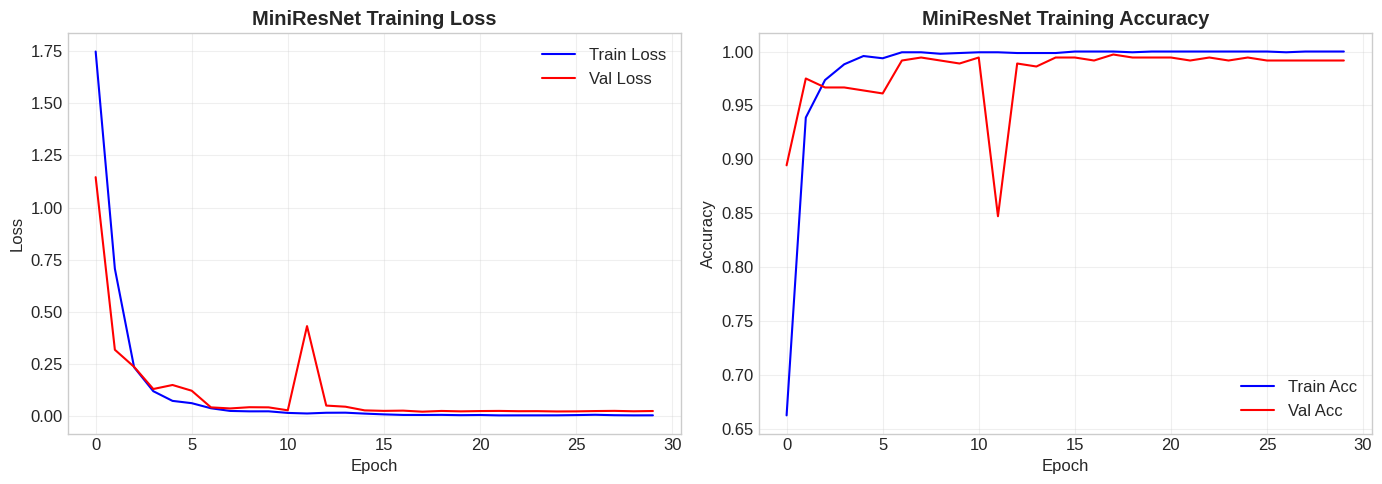

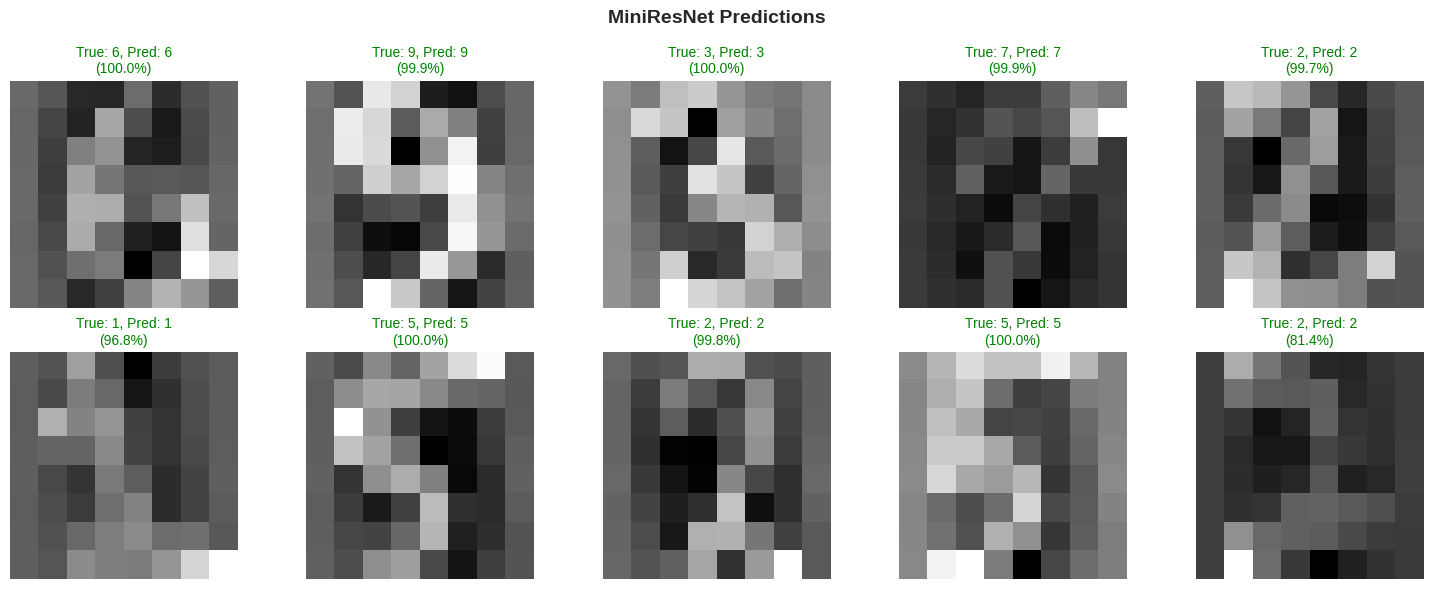

In [29]:
# ============================================================================
#                    VISUALIZE TRAINING RESULTS
# ============================================================================

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history['train_loss'], 'b-', label='Train Loss')
ax1.plot(history['val_loss'], 'r-', label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('MiniResNet Training Loss', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history['train_acc'], 'b-', label='Train Acc')
ax2.plot(history['val_acc'], 'r-', label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('MiniResNet Training Accuracy', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('MiniResNet Predictions', fontsize=14, fontweight='bold')

resnet_model.eval()
with torch.no_grad():
    X_sample = X_test[:10].to(device)
    predictions = resnet_model(X_sample)
    probs = F.softmax(predictions, dim=1)
    pred_classes = predictions.argmax(dim=1).cpu()

for i, ax in enumerate(axes.flatten()):
    img = X_test[i, 0].numpy()
    true_label = y_test[i].item()
    pred_label = pred_classes[i].item()
    confidence = probs[i, pred_label].item() * 100

    ax.imshow(img, cmap='gray')
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label}, Pred: {pred_label}\n({confidence:.1f}%)',
                 color=color, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [30]:
# ============================================================================
#                         ADVANCED CHEAT SHEET
# ============================================================================

print("="*70)
print("                 ADVANCED PYTORCH CHEAT SHEET")
print("="*70)

cheat_sheet = """
AUTOGRAD PATTERNS
-----------------
# Basic gradient
y = model(x)
y.backward()
grads = [p.grad for p in model.parameters()]

# Higher-order derivatives
dy_dx = torch.autograd.grad(y, x, create_graph=True)[0]
d2y_dx2 = torch.autograd.grad(dy_dx, x)[0]

# Jacobian and Hessian
jacobian = torch.autograd.functional.jacobian(f, x)
hessian = torch.autograd.functional.hessian(f, x)

# Custom autograd function
class CustomOp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return forward_result
    @staticmethod
    def backward(ctx, grad_output):
        x, = ctx.saved_tensors
        return custom_gradient

CUSTOM nn.Module LAYERS
-----------------------
class CustomLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        return x @ self.weight + self.bias

CUSTOM TRAINING
---------------
# Training loop
model.train()
for x, y in train_loader:
    optimizer.zero_grad()
    loss = loss_fn(model(x), y)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
scheduler.step()

# Validation loop
model.eval()
with torch.no_grad():
    for x, y in val_loader:
        outputs = model(x)

GRADIENT MANIPULATION
---------------------
# Clip by global norm
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# Gradient accumulation
for i, (x, y) in enumerate(loader):
    loss = loss_fn(model(x), y) / accumulation_steps
    loss.backward()
    if (i + 1) % accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()

# Gradient hooks
handle = tensor.register_hook(lambda grad: grad.clamp(-1, 1))
"""
print(cheat_sheet)

                 ADVANCED PYTORCH CHEAT SHEET

AUTOGRAD PATTERNS
-----------------
# Basic gradient
y = model(x)
y.backward()
grads = [p.grad for p in model.parameters()]

# Higher-order derivatives
dy_dx = torch.autograd.grad(y, x, create_graph=True)[0]
d2y_dx2 = torch.autograd.grad(dy_dx, x)[0]

# Jacobian and Hessian
jacobian = torch.autograd.functional.jacobian(f, x)
hessian = torch.autograd.functional.hessian(f, x)

# Custom autograd function
class CustomOp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return forward_result
    @staticmethod
    def backward(ctx, grad_output):
        x, = ctx.saved_tensors
        return custom_gradient

CUSTOM nn.Module LAYERS
-----------------------
class CustomLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = nn.Parameter(torch.zeros(out_feat

---

# Conclusion

## Your Advanced PyTorch Journey

Congratulations! You've mastered advanced PyTorch techniques.

### What You Learned

| Part | Topic | Key Takeaway |
|------|-------|-------------|
| I | Advanced Autograd | Nested autograd, Jacobians, custom functions |
| II | Building Ops | Conv, pooling, normalization from scratch |
| III | Primitive Layers | Dense, Conv2D with only basic tensors |
| IV | Custom nn.Module | Proper subclassing with nn.Parameter |
| V | Advanced Architectures | ResNet, SE-Net, Transformer blocks |
| VI | Custom Training | Full control with manual training loops |
| VII | Practical Demos | Real-world model combining everything |

### When to Use What

| Approach | Use When |
|----------|----------|
| Standard `nn.Module` | Most deep learning tasks |
| Custom `autograd.Function` | Non-differentiable ops, custom gradients |
| Custom training loop | GANs, RL, complex multi-model training |
| Gradient hooks | Debugging, visualization, per-layer manipulation |
| Primitive layers | Learning, debugging, maximum control |

### The Complete Learning Path

1. **NumPy from Scratch** - Understand the math deeply
2. **PyTorch Part 1** - Fundamentals and high-level API
3. **PyTorch Part 2** - Advanced custom components (This notebook!)
4. **TensorFlow/Keras** - Alternative framework comparison

### Next Steps

- **Vision Transformers (ViT)** - Transformers for images
- **Diffusion Models** - State-of-the-art generative AI
- **Distributed Training** - Multi-GPU with DDP
- **Model Optimization** - TorchScript, quantization, pruning
- **PyTorch Lightning** - Even cleaner training code

---

*"The more you understand the primitives, the better you can innovate."*

**Happy Deep Learning!**